### 1. Dataset retrieved from Kaggle at https://www.kaggle.com/fedesoriano/heart-failure-prediction

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Loading dataset
df = pd.read_csv("path_to_folder/heart.csv")
print(df)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N  

### 2.	Building data visualizations with Python to help understanding which variables have an impact on heart disease 

In [445]:
#Analytical description of numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [174]:
#Analytical description of categorical variables
df.describe(include=object).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


<AxesSubplot:>

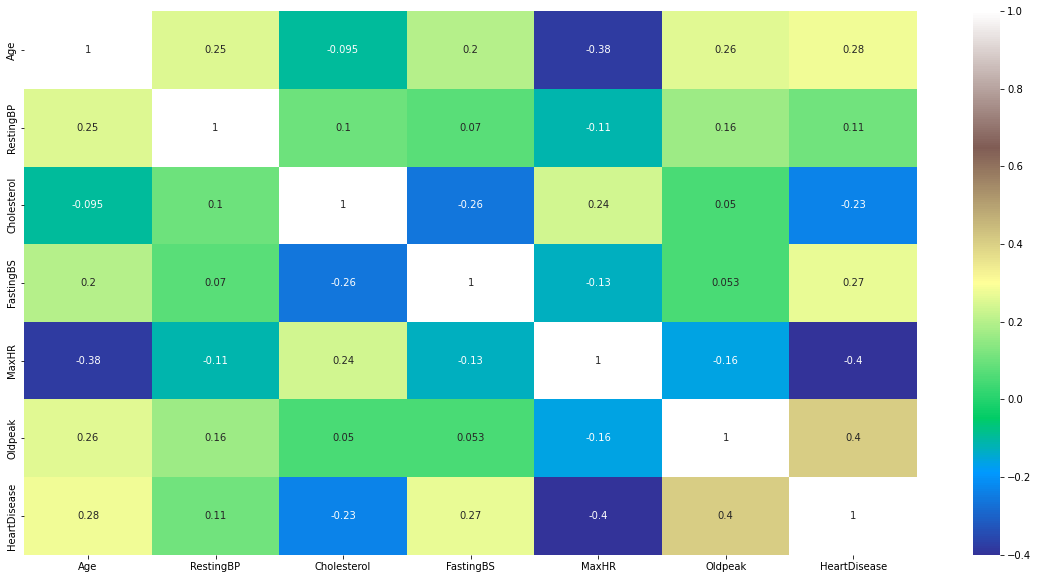

In [4]:
#Correlation between numerical variables
#CONCLUSION: heart diseases show positive correlation with the variables Age, RestingBP (low correlation), FastingBS and Oldpeak, and negative correlation
#with the variables Cholesterol and MaxHR.

plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='terrain')

In [446]:
#Dividing the dataset in numerical and categorical variables.

numerical = df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']].copy()
categorical = df[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']].copy()

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  _check_argument("element", ["bars", "step", "poly"], element)


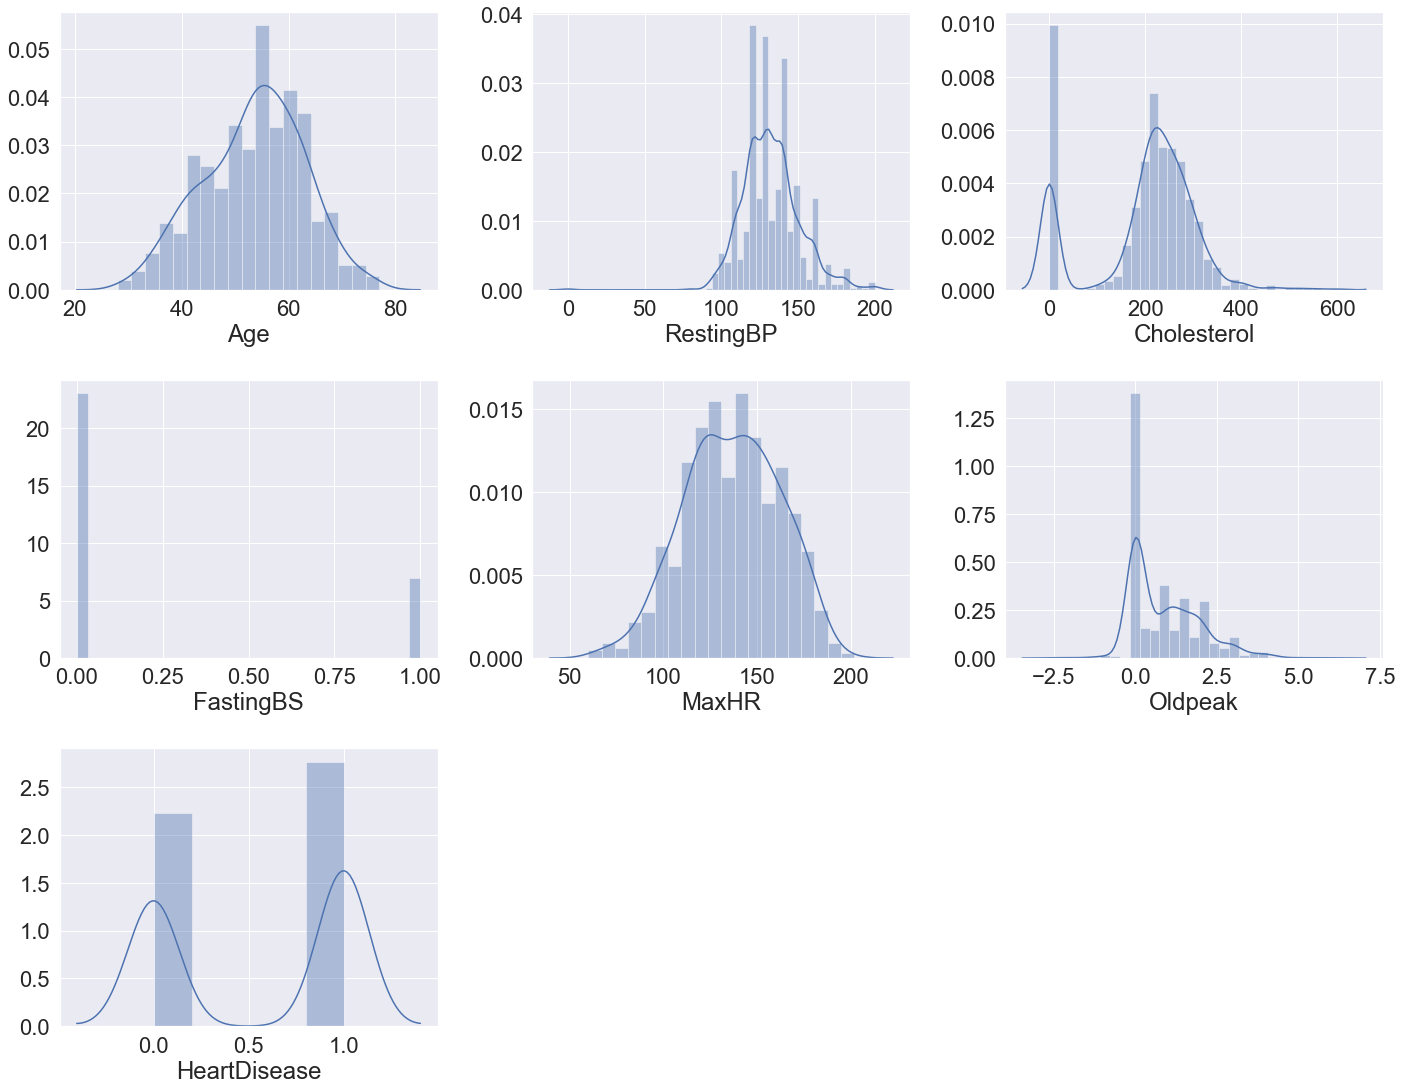

In [448]:
#Looking at the distribution of values of each numeric variable.
#CONCLUSION: the variable Cholesterol shows a a high number (172) of entries equal to 0, which a meaningless value
#for this variable. This indicates issues with data collection and curation. Thus, the cholesterol value should not
#be considered to build the classification model.

plt.figure(figsize=(20,20))
index = 0
for index, feature in enumerate(numerical):
    index += 1
    plt.subplot(4, 3, index)
    plt.tight_layout()
    sns.distplot(numerical[feature])

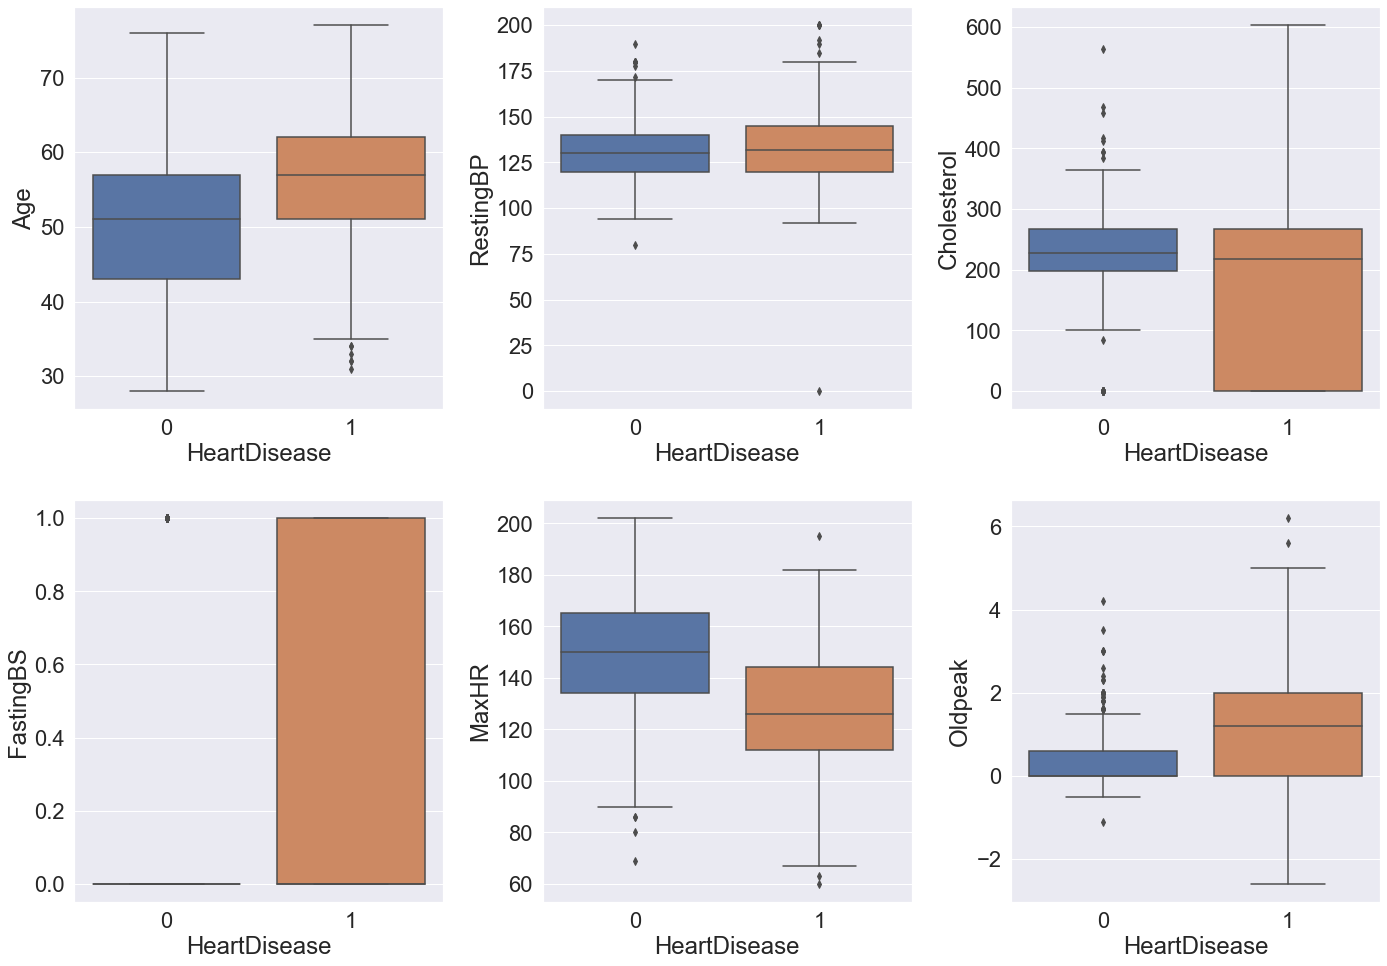

In [221]:
#Analysis of the influence of numeric variables on heart disease.
#CONCLUSION: higher Age and Oldpeak values and lower MaxHR show some correlation with heart disease, as observed
#in the Heatmap above

index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(3, 3, index)
        plt.tight_layout()
        sns.boxplot(x='HeartDisease', y=feature, data=df)

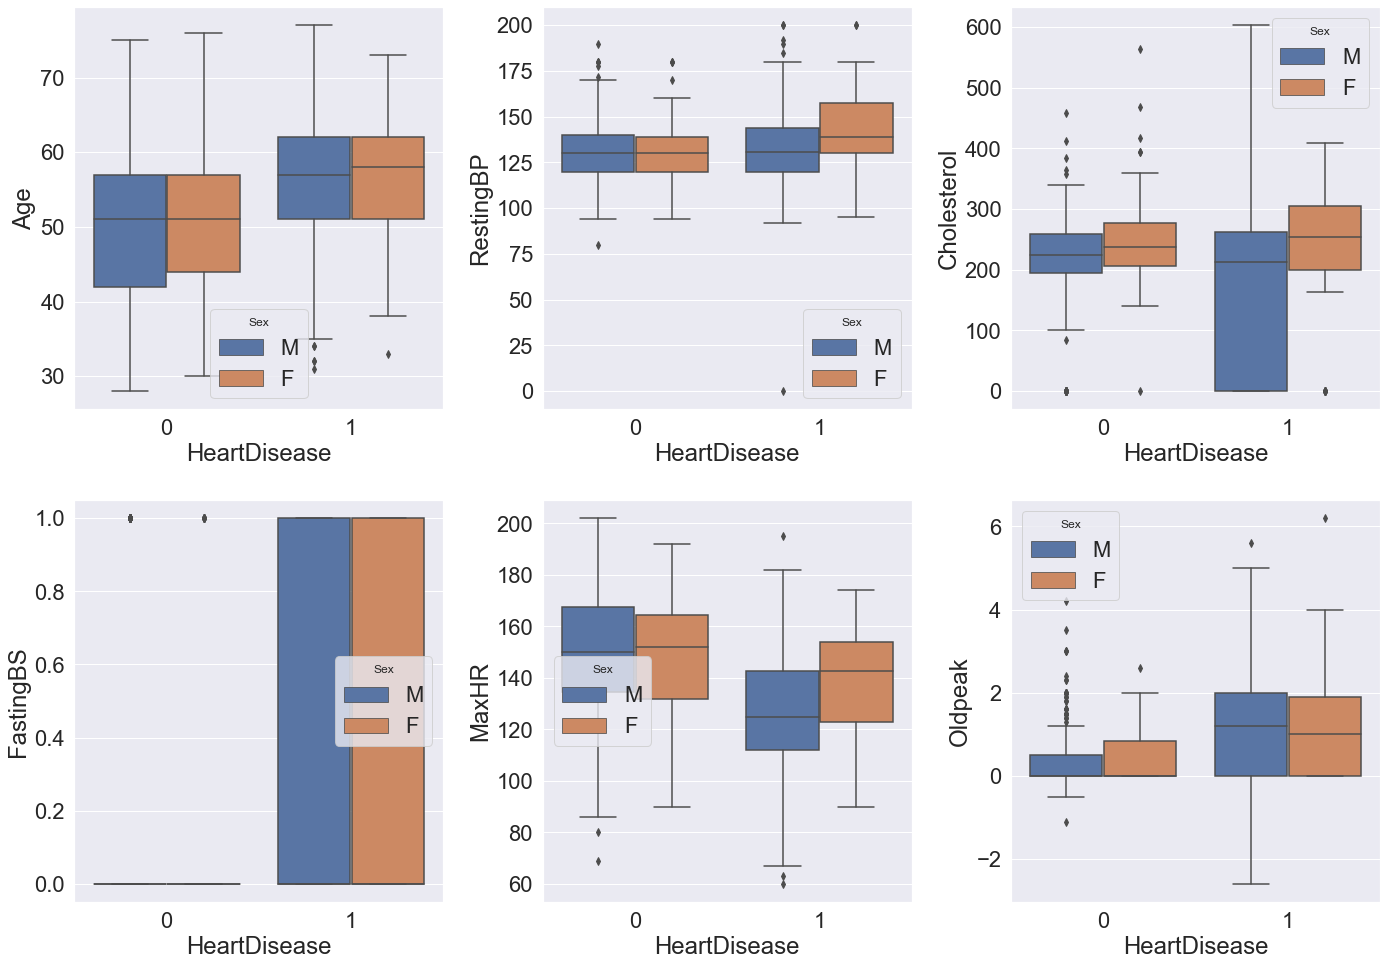

In [212]:
#Same as avobe, but split by Sex.

index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(3, 3, index)
        plt.tight_layout()
        sns.boxplot(x='HeartDisease', y=feature, hue='Sex', data=df)

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  _check_argument("element", ["bars", "step", "poly"], element)


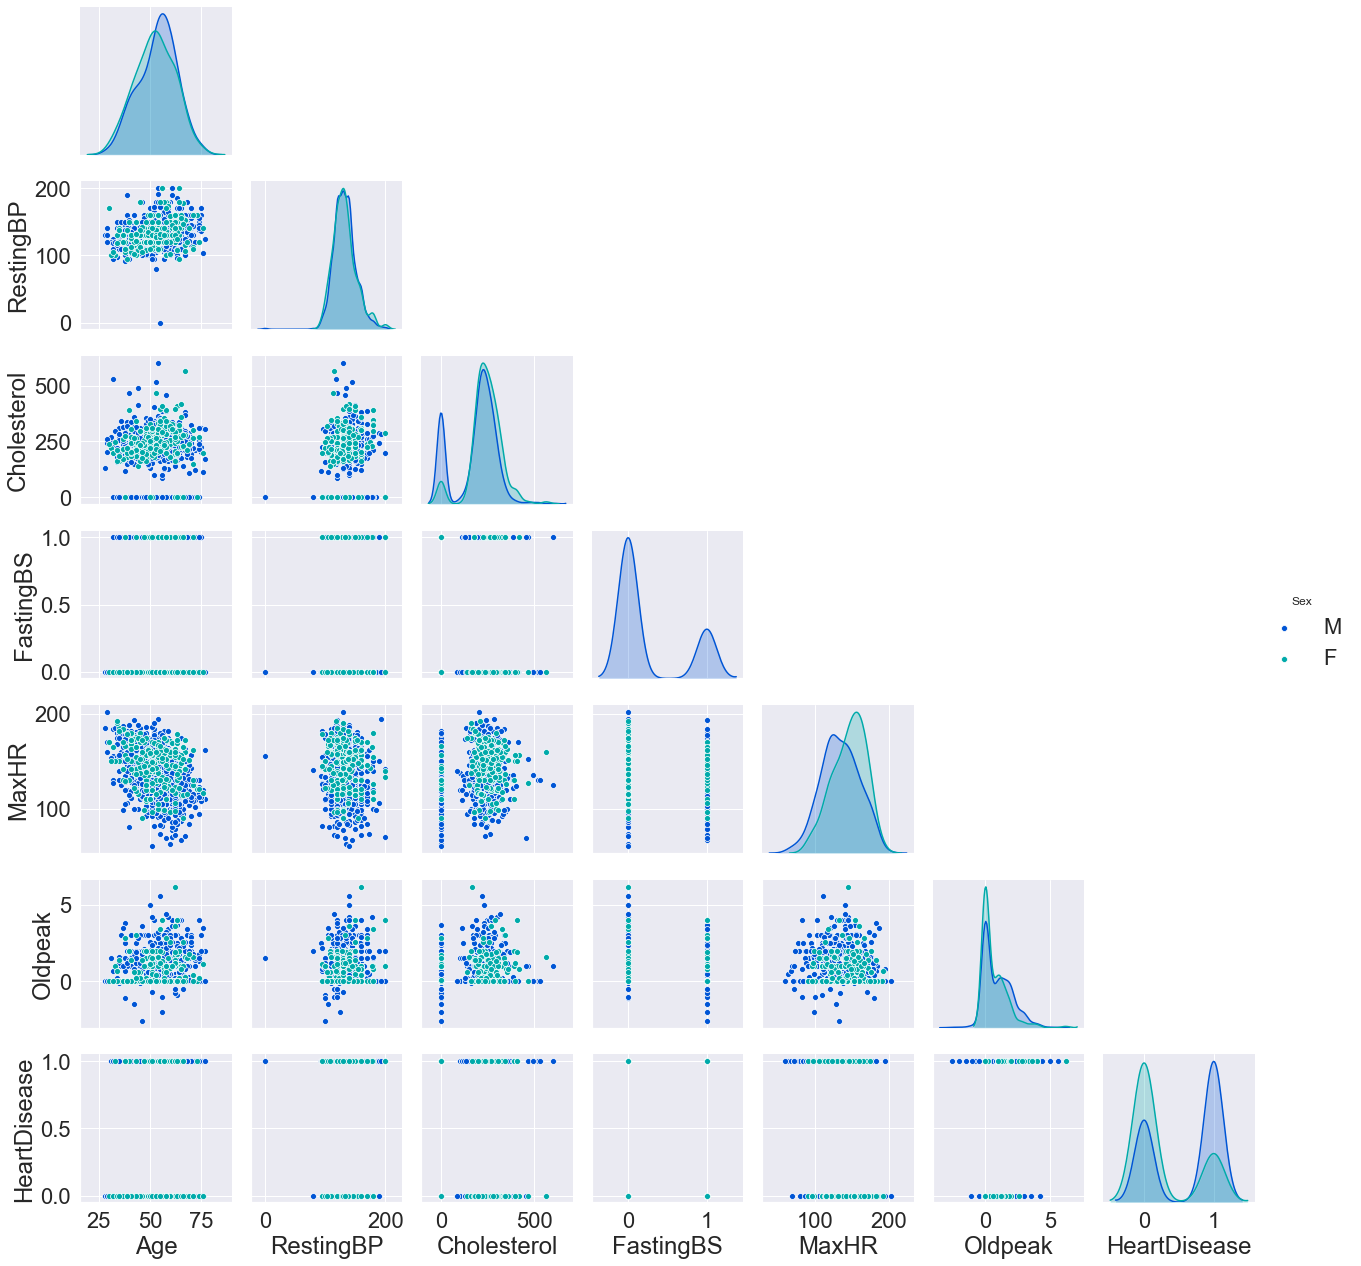

In [220]:
#Another visualization mode for the distribution of values of the numerical variables.
sns.pairplot(df, hue="Sex", palette="winter", corner=True)

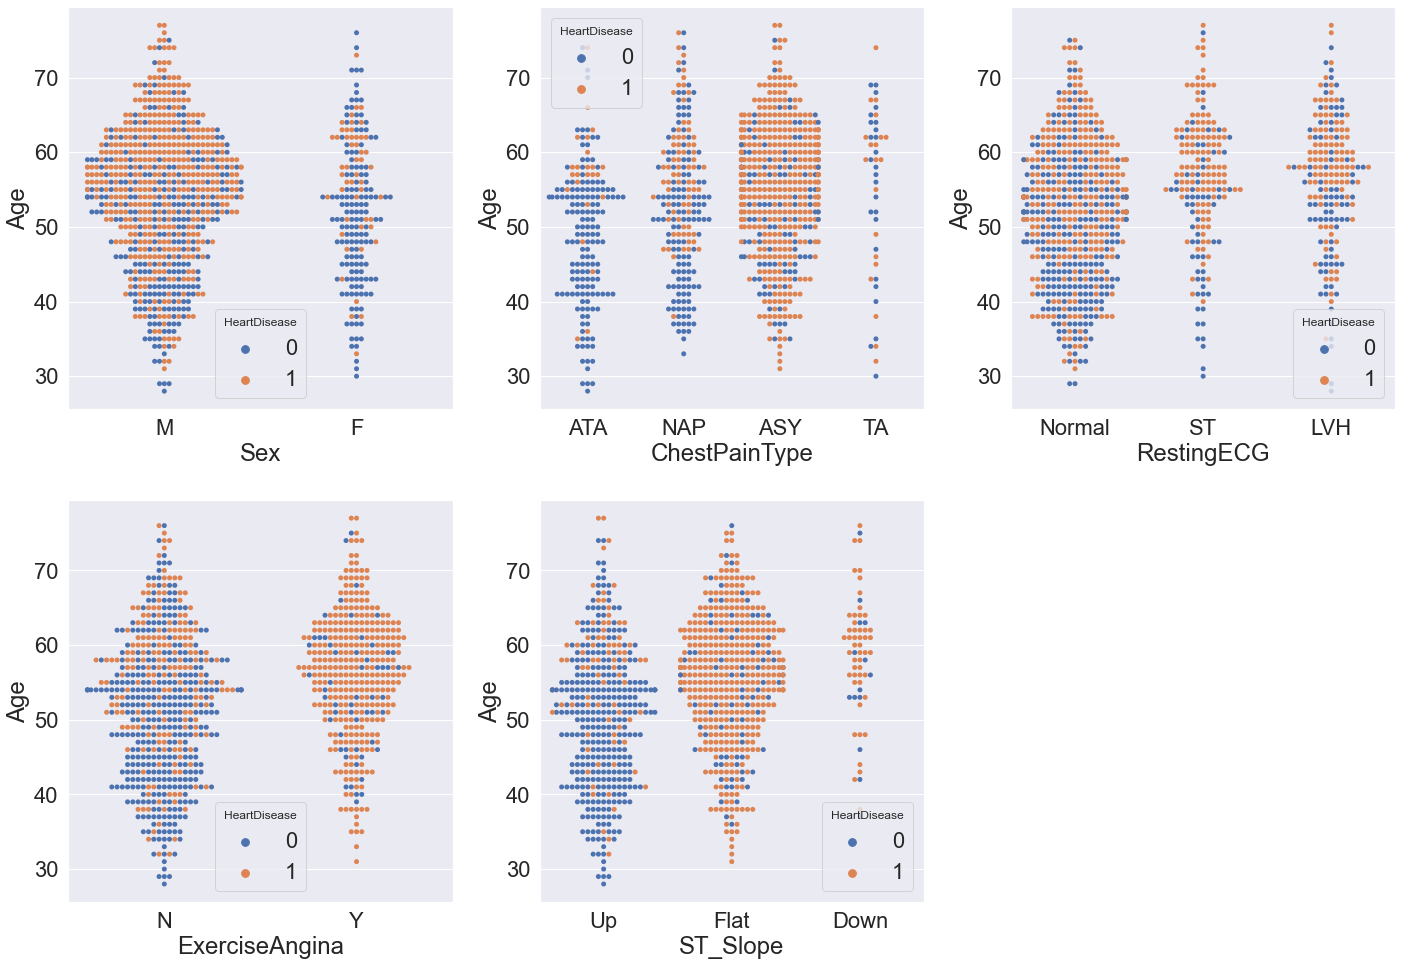

In [219]:
#Analysis of how the categorical variables, against the variable Age, influence heart disease. 
#CONCLUSION: a higher chance of heart disease is observed in men (M) compared to women (F), when 
#ChestPainType = ASY (Asymptomatic), when ExerciseAngina occurs (Y), and when ST_Slope is Flat or Down.

index = 0
plt.figure(figsize=(20,20))
for feature in categorical:
    index += 1
    plt.subplot(3, 3, index)
    plt.tight_layout()
    sns.swarmplot(y="Age", x=feature, hue='HeartDisease', data=df)

In [276]:
#Assesing multicollinearity with Variable Inflation Factors (VIF)
#CONCLUSION: All VIF values are close to 1, meaning that there is no multicollinearity among the variables that
#will be used to build the predictive model. Hence, predictive models can be built without the need to previously
#apply dimensionality reduction methods (e.g. PCA).

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Building the matrix for linear regression using HeartDisease as response variable.
y, X = dmatrices('HeartDisease ~ Age+RestingBP+Cholesterol+FastingBS+MaxHR+Oldpeak', data=numerical, return_type='dataframe')

#VIF calculation for each numerical variable that will be used to predict the variable HeartDisease 
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,1.000000,Intercept
1,1.312476,Age
2,1.102631,RestingBP
3,1.156728,Cholesterol
4,1.112829,FastingBS
5,1.240156,MaxHR
6,1.096548,Oldpeak


### 3.	Building a classification model to predict the probability of heart failure

In [5]:
#Import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [6]:
#Due to the clear correlation of some categorical variables on heart disease (see swarmplots above), they are
#converted to numeric variables below in order to include them in the predictive model. 

df['Sex'] = pd.factorize(df['Sex'])[0]
df['ChestPainType'] = pd.factorize(df['ChestPainType'])[0]
df['RestingECG'] = pd.factorize(df['RestingECG'])[0]
df['ExerciseAngina'] = pd.factorize(df['ExerciseAngina'])[0]
df['ST_Slope'] = pd.factorize(df['ST_Slope'])[0]
print(df)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    0              0        140          289          0           0   
1     49    1              1        160          180          0           0   
2     37    0              0        130          283          0           1   
3     48    1              2        138          214          0           0   
4     54    0              1        150          195          0           0   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    0              3        110          264          0           0   
914   68    0              2        144          193          1           0   
915   57    0              2        130          131          0           0   
916   57    1              0        130          236          0           2   
917   38    0              1        138          175          0           0   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

### I chose Logistic Regression as the best classification model to predict the variable HeartDisease. This decission is based on the fact that HeartDisease is a binary categorical variable that only takes the values 0 (no heart disease) and 1 (presence of heart disease). Logistic Regression is a classification algorithm that predicts a binary result as a function of independent variables, and generates models that are easy to interpret. As shown below, Logistic Regression produces, together with Random Forest, the classification model of highest accuracy (89%). 

In [8]:
# Logistic Regression
X = df.drop(["HeartDisease","Cholesterol"], axis=1) #Selection of variables to be used in the predictive model
y = df["HeartDisease"] #Selection of the variable to be predicted

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 40)
lr=LogisticRegression(class_weight=None, random_state=101, solver='saga', max_iter=10000)

lrmodel=lr.fit(X_train,y_train)
lrpred=lrmodel.predict(X_test)
lraccuracy = accuracy_score(y_test,lrpred)
lrcoefficients = lr.coef_[0]

print(f'The accuracy of the Logistic Regression model is: {lraccuracy}')
# List of coefficients that indicate the contribution of each variable to the predictive model, following 
# the order of the variables in the dataframe X 
print(f'The coefficients of the Logistic Regression model are: {lrcoefficients}') 

The accuracy of the Logistic Regression model is: 0.8858695652173914
The coefficients of the Logistic Regression model are: [ 0.01045568 -0.87966748  0.70241399 -0.00177163  0.90064941 -0.00941437
 -0.01857766  0.92348233  0.35568613  1.25319542]


### Comparison of the accuracy of the Logistic Regression classification model with other classification methods (e.g. Random Forest, Decision Tree, etc)

In [9]:
# Random Forest
# Note: although the Random Forest model shows the same accuracy as Logistic Regression, the latter has the 
# advantage of being very easy to interpret via a list of coefficients which indicate the contribution of each
# variable to the predictive model.

rf = RandomForestClassifier(n_estimators=30, criterion = 'entropy', random_state=50, class_weight='balanced', max_depth=5)
rfmodel = rf.fit(X_train, y_train)
rfpred=rfmodel.predict(X_test)
rfaccuracy = accuracy_score(y_test,rfpred)
print(f'The accuracy of the Random Forest model is: {rfaccuracy}')


The accuracy of the Random Forest model is: 0.8858695652173914


In [10]:
# Decision Tree 
decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=50, class_weight=None)
dcmodel = decision_tree.fit(X_train, y_train)
dcpred = dcmodel.predict(X_test)
dcaccuracy = accuracy_score(y_test,dcpred)
print(f'The accuracy of the Decision Tree model is: {dcaccuracy}')

The accuracy of the Decision Tree model is: 0.7717391304347826


In [11]:
# K-Nearest Neighbors Classifier (KNN)
knn = KNeighborsClassifier()
knnmodel = knn.fit(X_train, y_train) 
knnpred = knnmodel.predict(X_test)
knnaccuracy = accuracy_score(y_test,knnpred)
print(f'The accuracy of the KNN model is: {knnaccuracy}')

The accuracy of the KNN model is: 0.6467391304347826


In [12]:
# Support Vector Classifier (SVC)
svc = SVC(random_state=101, class_weight=None)
svc.fit(X_train, y_train) 
svcmodel = svc.fit(X_train, y_train) 
svcpred = svcmodel.predict(X_test)
svcaccuracy = accuracy_score(y_test,svcpred)
print(f'The accuracy of the SVC model is: {svcaccuracy}')

The accuracy of the SVC model is: 0.7119565217391305
